# Telecom Churn Prediction - Notebook

## 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [2]:
#Data Structures
import pandas as pd
import numpy as np
import re

#Preprocessing
import missingno as msno ## run !pip install missingno to install library
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Pipeline dependencies
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from tensorflow.keras import layers, Model, utils, Sequential
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [3]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [4]:
l = ['- '+data_dict.iloc[i,0].strip()+' : '+data_dict.iloc[i,1].strip() for i in range(len(data_dict))]
for i in l:
    print(i)

- CIRCLE_ID : Telecom circle area to which the customer belongs to
- LOC : Local calls  within same telecom circle
- STD : STD calls  outside the calling circle
- IC : Incoming calls
- OG : Outgoing calls
- T2T : Operator T to T ie within same operator mobile to mobile
- T2M : Operator T to other operator mobile
- T2O : Operator T to other operator fixed line
- T2F : Operator T to fixed lines of T
- T2C : Operator T to its own call center
- ARPU : Average revenue per user
- MOU : Minutes of usage  voice calls
- AON : Age on network  number of days the customer is using the operator T network
- ONNET : All kind of calls within the same operator network
- OFFNET : All kind of calls outside the operator T network
- ROAM : Indicates that customer is in roaming zone during the call
- SPL : Special calls
- ISD : ISD calls
- RECH : Recharge
- NUM : Number
- AMT : Amount in local currency
- MAX : Maximum
- DATA : Mobile internet
- 3G : G network
- AV : Average
- VOL : Mobile internet usage vol

In [5]:
print(data_dict)

       Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator ne

In [6]:
data.head() 

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [6]:
# ids = ['id','circle_id']
# total_amounts = [i for i in list(train.columns) if re.search('total.+amt',i)]
# total_outgoing_minutes = [i for i in list(train.columns) if re.search('total.+og.+mou',i)]
# offnetwork_minutes = [i for i in list(train.columns) if re.search('offnet',i)]
# average_revenue_3g = [i for i in list(train.columns) if re.search('arpu.+3g',i)]
# average_revenue_2g = [i for i in list(train.columns) if re.search('arpu.+2g',i)]
# volume_3g = [i for i in list(train.columns) if re.search('vol.+3g',i)]
# volume_2g = [i for i in list(train.columns) if re.search('vol.+2g',i)]
# age_on_network = [i for i in list(train.columns) if re.search('aon',i)]

# #Storing them in a single flat list
# variables = [*ids, 
#              *total_amounts, 
#              *total_outgoing_minutes, 
#              *offnetwork_minutes, 
#              *average_revenue_3g, 
#              *average_revenue_2g,
#              *volume_3g,
#              *volume_2g,
#              *age_on_network, 
#              'churn_probability']

data = data.set_index('id')

In [7]:
data.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,0.000,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,111.095,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,101.565,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


Let's look at each variable's datatype:

In [8]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    circle_id                 int64  
 1    loc_og_t2o_mou            float64
 2    std_og_t2o_mou            float64
 3    loc_ic_t2o_mou            float64
 4    last_date_of_month_6      object 
 5    last_date_of_month_7      object 
 6    last_date_of_month_8      object 
 7    arpu_6                    float64
 8    arpu_7                    float64
 9    arpu_8                    float64
 10   onnet_mou_6               float64
 11   onnet_mou_7               float64
 12   onnet_mou_8               float64
 13   offnet_mou_6              float64
 14   offnet_mou_7              float64
 15   offnet_mou_8              float64
 16   roam_ic_mou_6             float64
 17   roam_ic_mou_7             float64
 18   roam_ic_mou_8             float64
 19   roam_og_mou_6             float64
 20   roam_og_m

In [9]:
data_num = data.select_dtypes(include=['int64','float64'])
data_num.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,0.0,0.0,0.0,31.277,87.009,7.527,48.58,124.38,1.29,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,109,0.0,0.0,0.0,0.000,122.787,42.953,0.00,0.00,0.00,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,109,0.0,0.0,0.0,60.806,103.176,0.000,0.53,15.93,0.00,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,109,0.0,0.0,0.0,156.362,205.260,111.095,7.26,16.01,0.00,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,109,0.0,0.0,0.0,240.708,128.191,101.565,21.28,4.83,6.13,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


Let's also summarize the features using the df.describe method:

In [10]:
data_num.describe(include="all")

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


In [11]:
dtypes = data.dtypes.reset_index().rename({'index':'col',0:'dtype'}, axis='columns')
dtypes['dtype'].value_counts()

dtype
float64    135
int64       27
object       9
Name: count, dtype: int64

In [12]:
numeric = dtypes[dtypes['dtype'].isin(['int64','float64'])]['col'].to_list()[1:-1]
dates = dtypes[dtypes['dtype']=='object']['col'].to_list()[3:]
target = ['churn_probability']

## 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [13]:
X = data[[*numeric, *dates]]
y = data[target]

X.shape, y.shape

((69999, 6), (69999, 1))

Splitting train and test data to avoid any contamination of the test data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 6), (14000, 6), (55999, 1), (14000, 1))

In [15]:
X_train.head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
id,,,,,,
13052,6/30/2014,7/29/2014,8/29/2014,NaN,NaN,NaN
68775,6/30/2014,7/27/2014,8/29/2014,NaN,NaN,NaN
65622,6/21/2014,7/23/2014,8/28/2014,6/13/2014,7/9/2014,NaN
19952,6/28/2014,7/29/2014,8/30/2014,NaN,NaN,NaN
48692,6/25/2014,7/16/2014,8/26/2014,6/25/2014,7/11/2014,NaN


## 3. Handling Missing data

https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

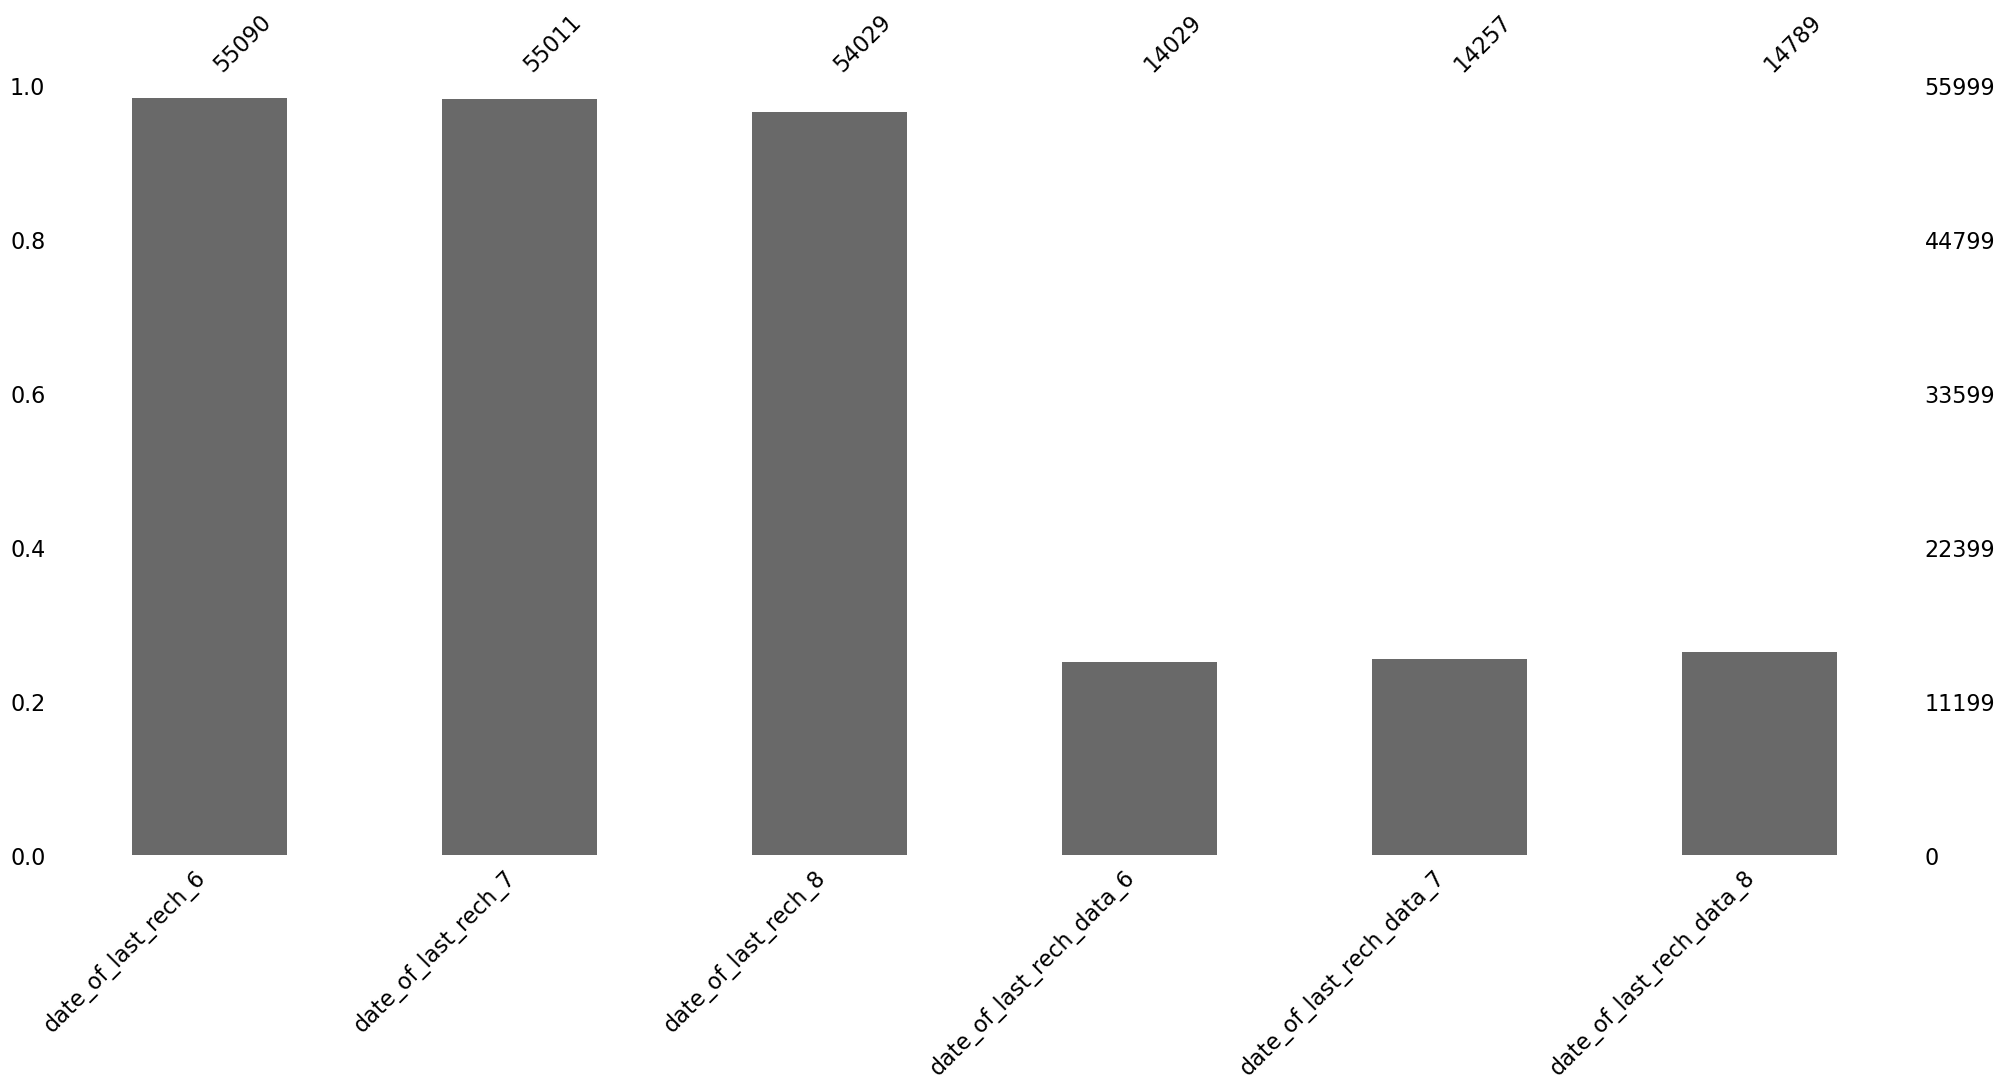

In [16]:
msno.bar(X_train)

Lets also calculate the % missing data for each column:

In [17]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

date_of_last_rech_6          1.623243
date_of_last_rech_7          1.764317
date_of_last_rech_8          3.517920
date_of_last_rech_data_6    74.947767
date_of_last_rech_data_7    74.540617
date_of_last_rech_data_8    73.590600
dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [18]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

In [19]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 3)

<Axes: >

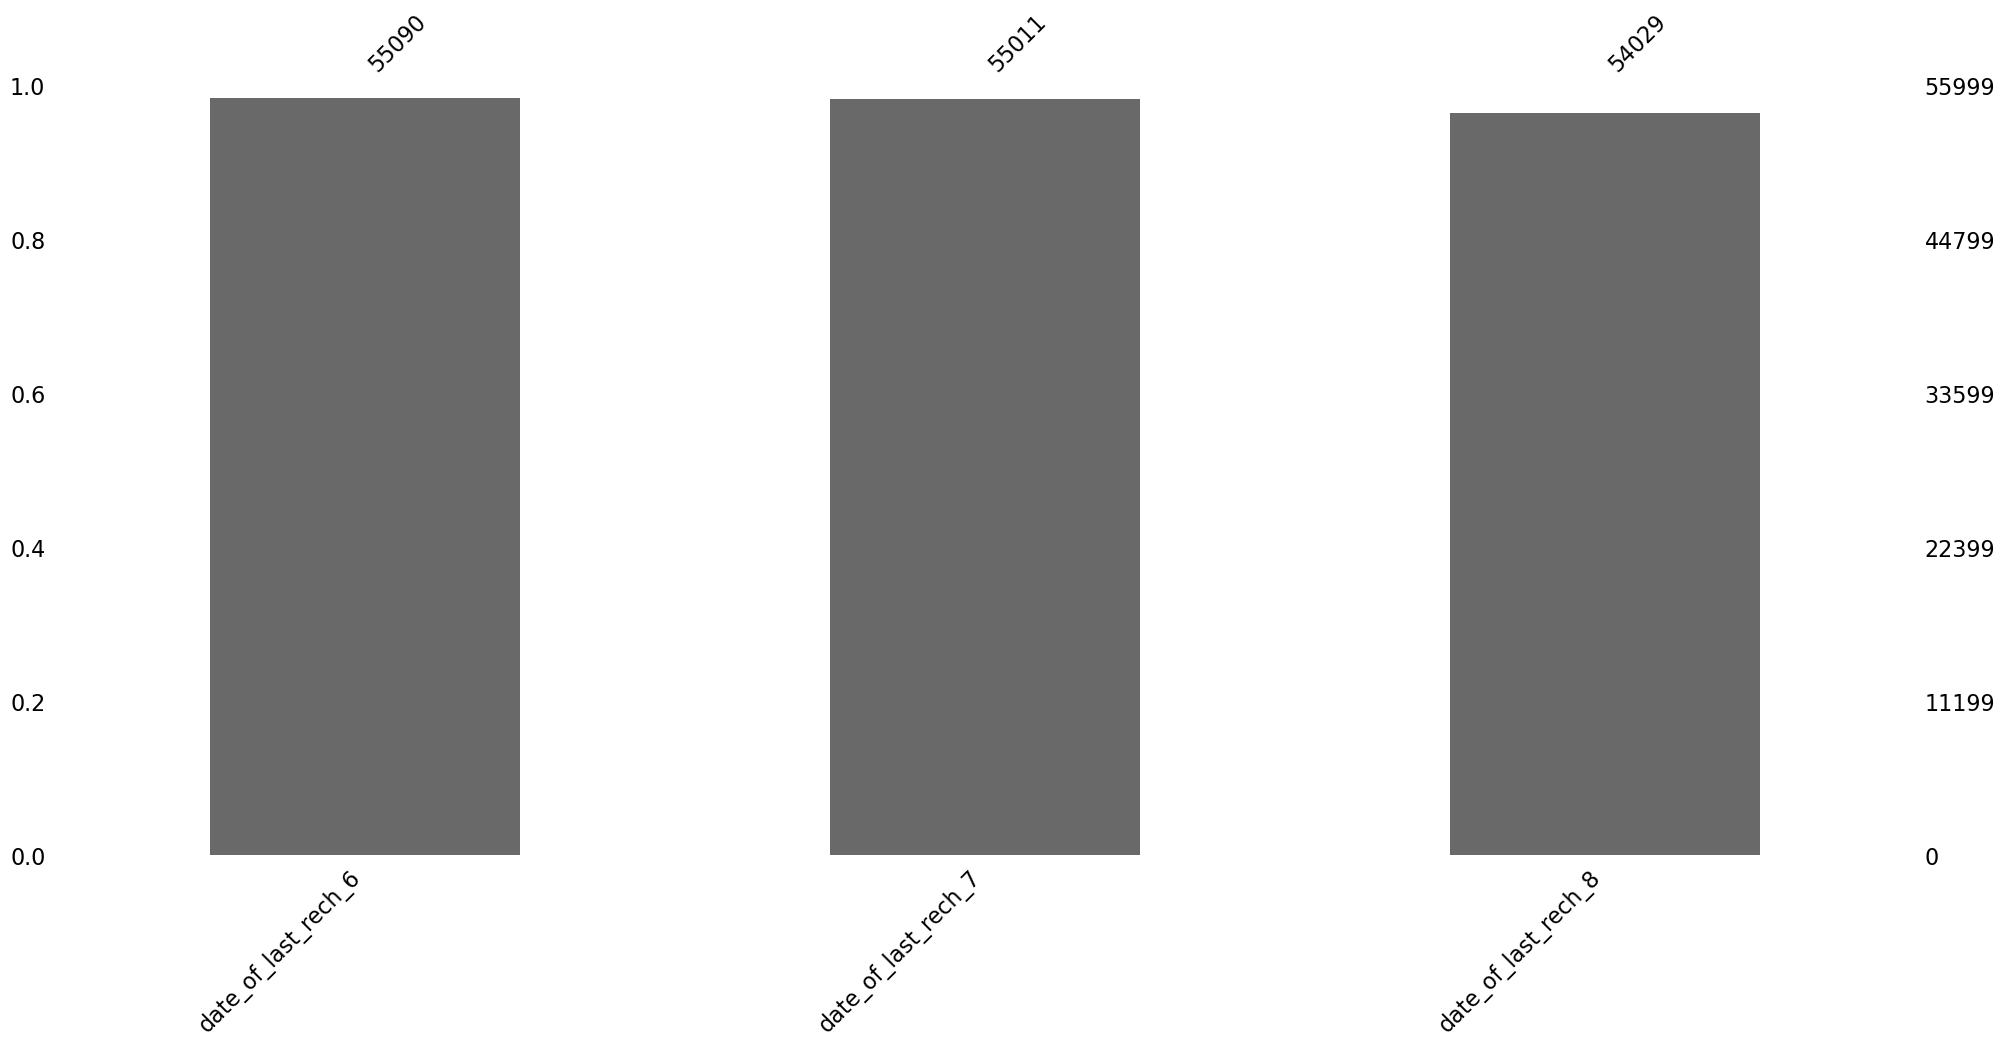

In [20]:
msno.bar(X_train_filtered)

Before we work with imputing missing data, we need the data in a format that allows us to use missing data strategies efficiently. Specially the date variables.

In [21]:
date_features = list(set(X_train_filtered.columns).intersection(set(dates)))
date_features

['date_of_last_rech_8', 'date_of_last_rech_7', 'date_of_last_rech_6']

In [22]:
dts = X_train_filtered[date_features].head()

We will calculate the number of days they have not recharged each month by subtracting last date of month and date of last recharge.

In [23]:
dts = dts.apply(lambda x: 31 - pd.to_datetime(x, format='%m/%d/%Y').dt.day)
dts.head()

,date_of_last_rech_8,date_of_last_rech_7,date_of_last_rech_6
id,,,
13052,2,2,1
68775,2,4,1
65622,3,8,10
19952,1,2,3
48692,5,15,6


In [24]:
X_train_filtered[date_features] = dts

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data - 

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [25]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

In [26]:
imp = SimpleImputer(strategy='mean')
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

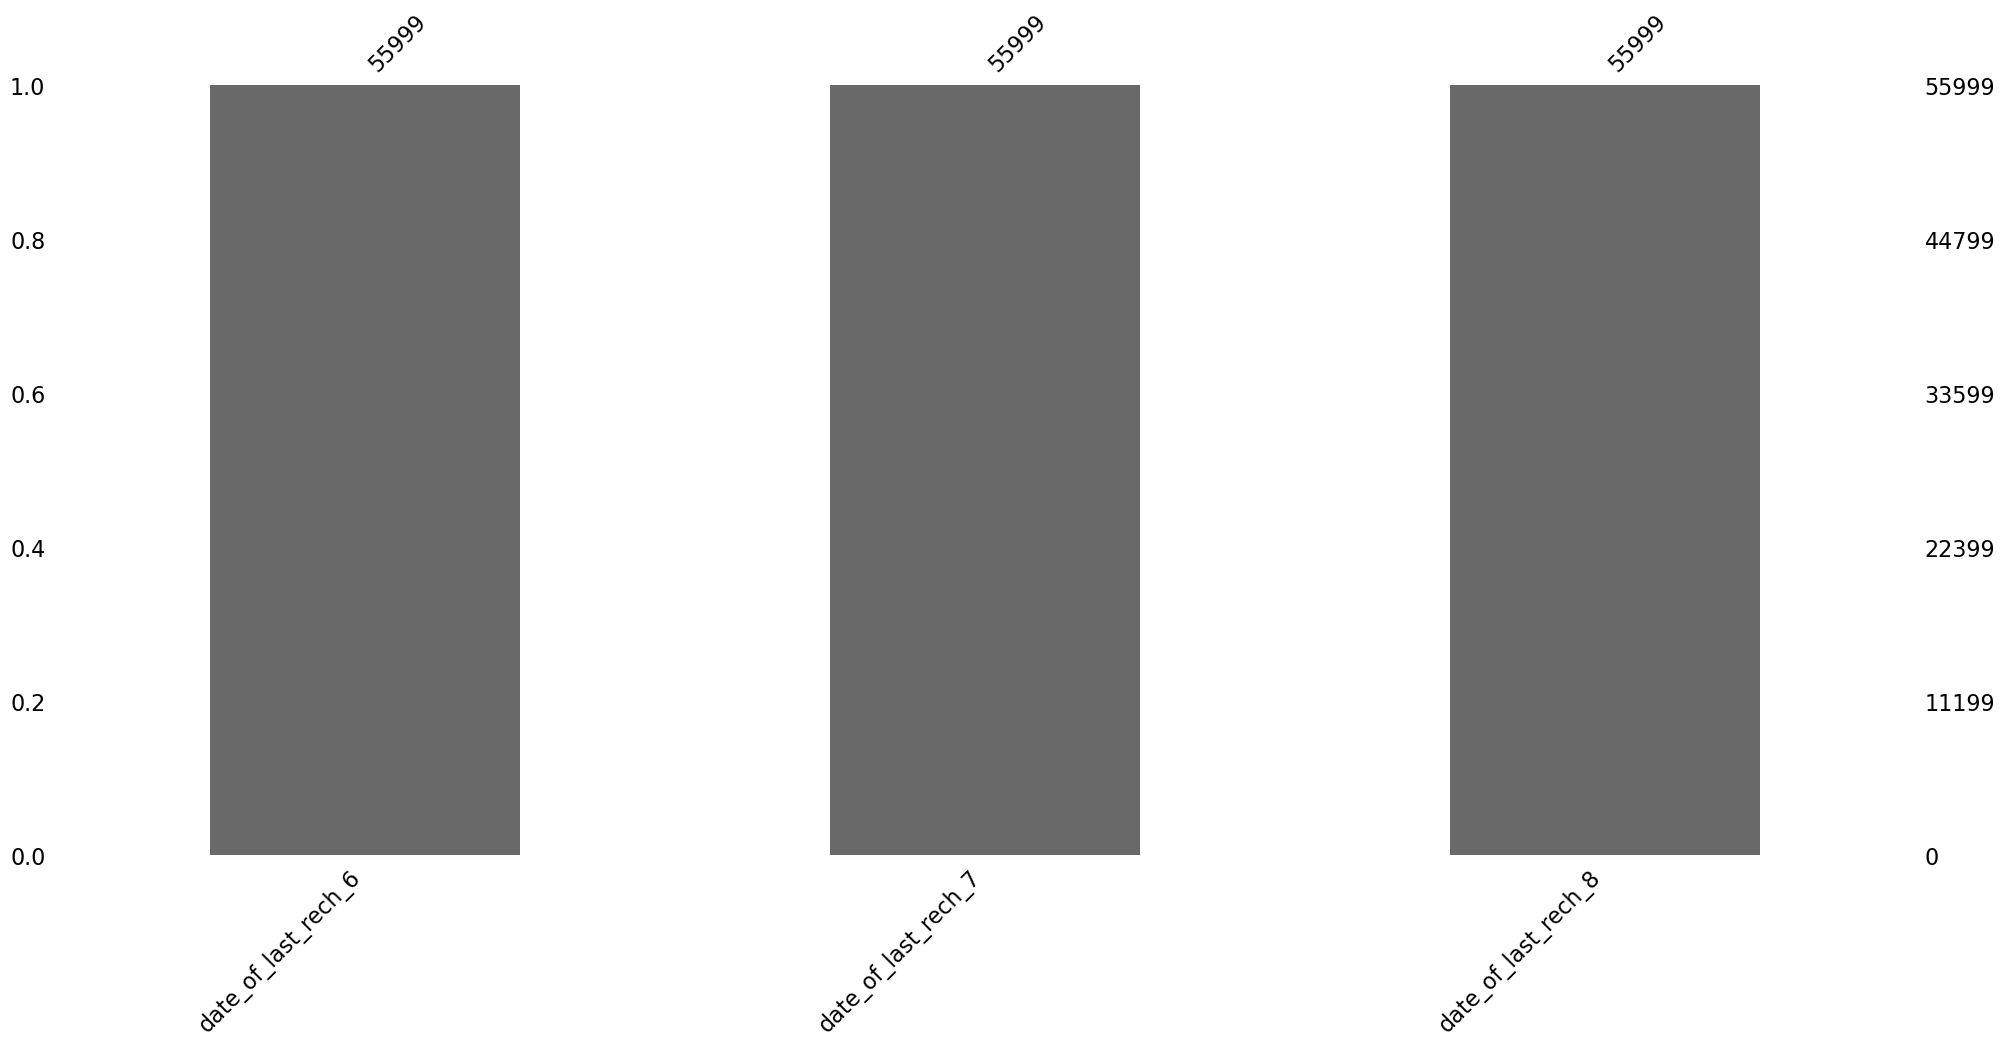

In [27]:
msno.bar(X_train_filtered)

In [28]:
X_train_filtered.describe()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
count,55999.000000,55999.000000,55999.000000
mean,4.200000,6.200000,2.600000
std,0.032404,0.046446,0.012818
min,1.000000,2.000000,1.000000
25%,4.200000,6.200000,2.600000
50%,4.200000,6.200000,2.600000
75%,4.200000,6.200000,2.600000
max,10.000000,15.000000,5.000000


## 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

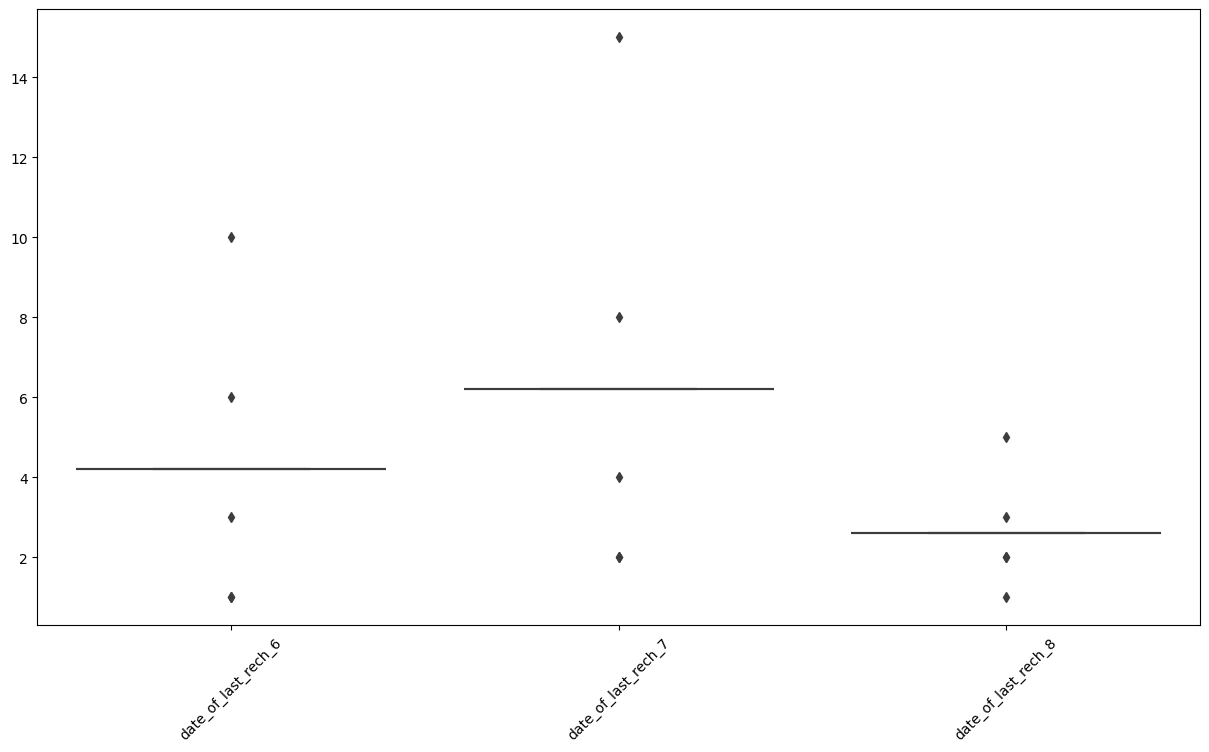

In [29]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [30]:
scale = StandardScaler()
X_train_filtered1 = scale.fit_transform(X_train_filtered)

<Axes: >

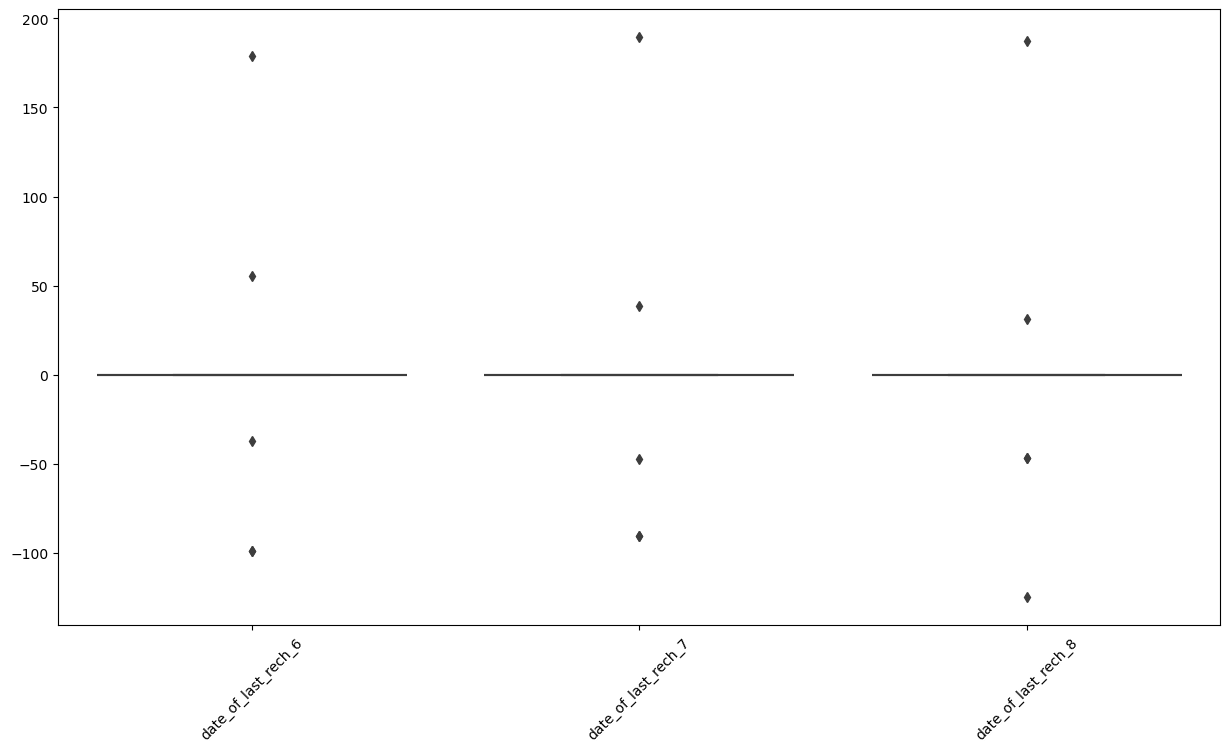

In [31]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered1, columns=new_vars))

### 4.2 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [32]:
X_train_filtered1 = pd.DataFrame(X_train_filtered1, columns=X_train_filtered.columns)

In [33]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

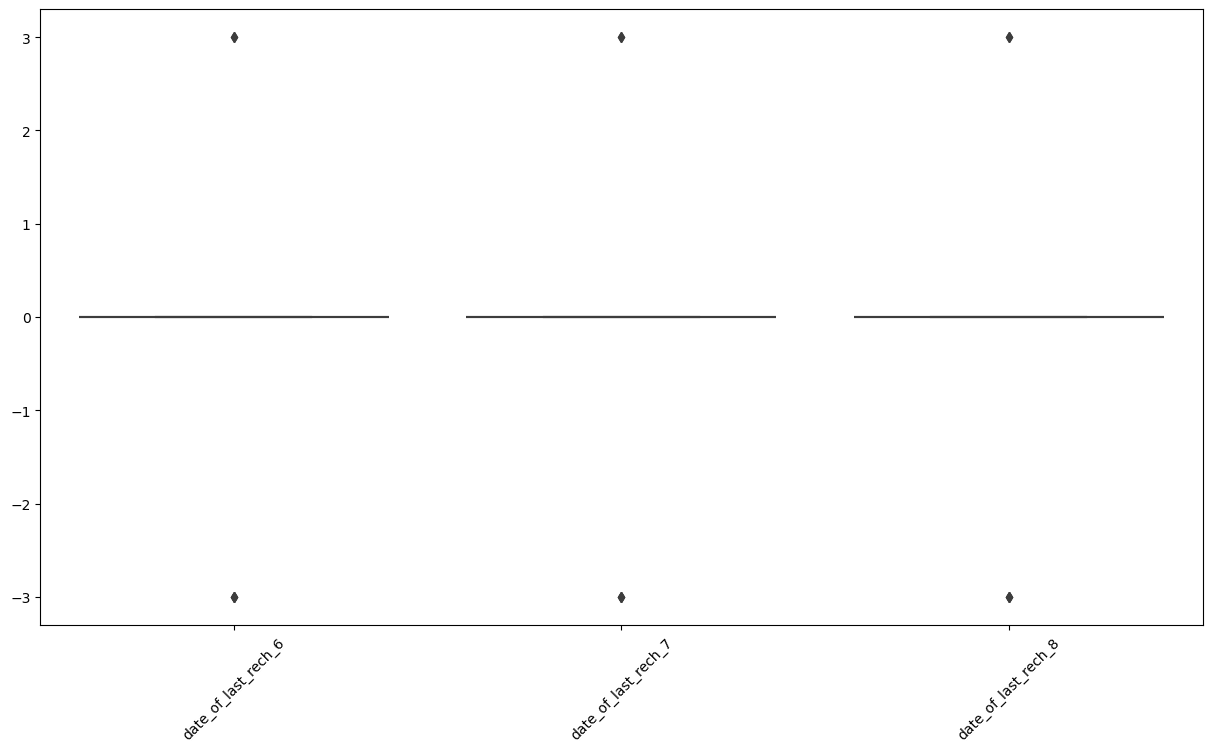

In [34]:
X_train_filtered2 = X_train_filtered1.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered2)

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

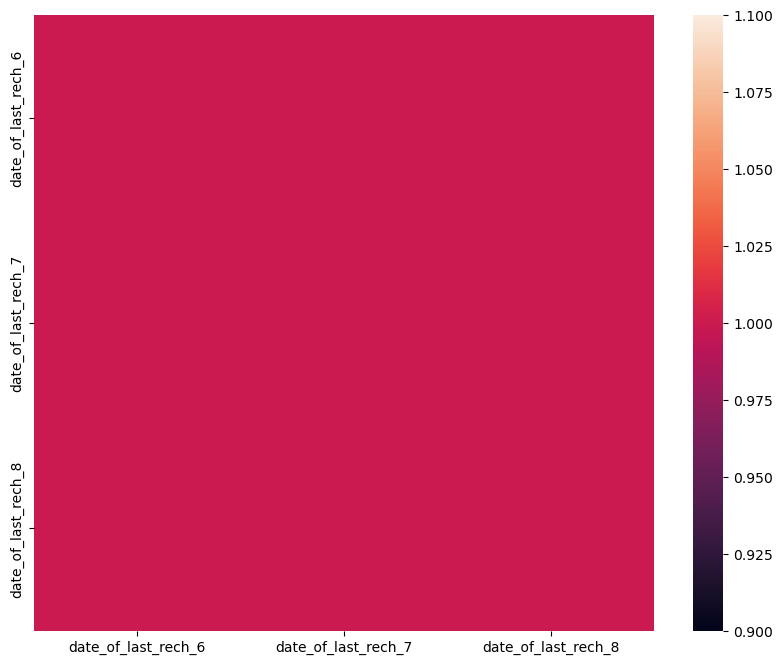

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: ylabel='Count'>

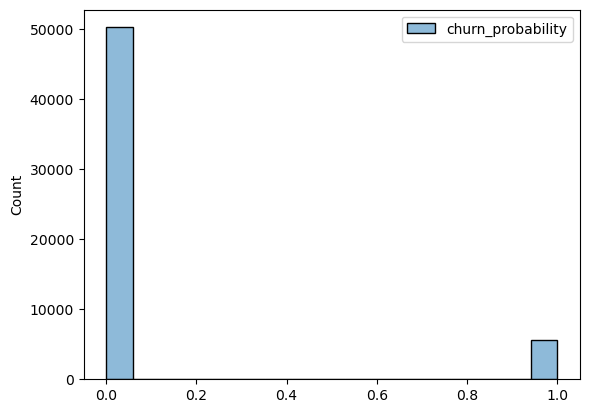

In [36]:
#Distribution for the churn probability
sns.histplot(y_train)

### 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [37]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [38]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 3 artists>

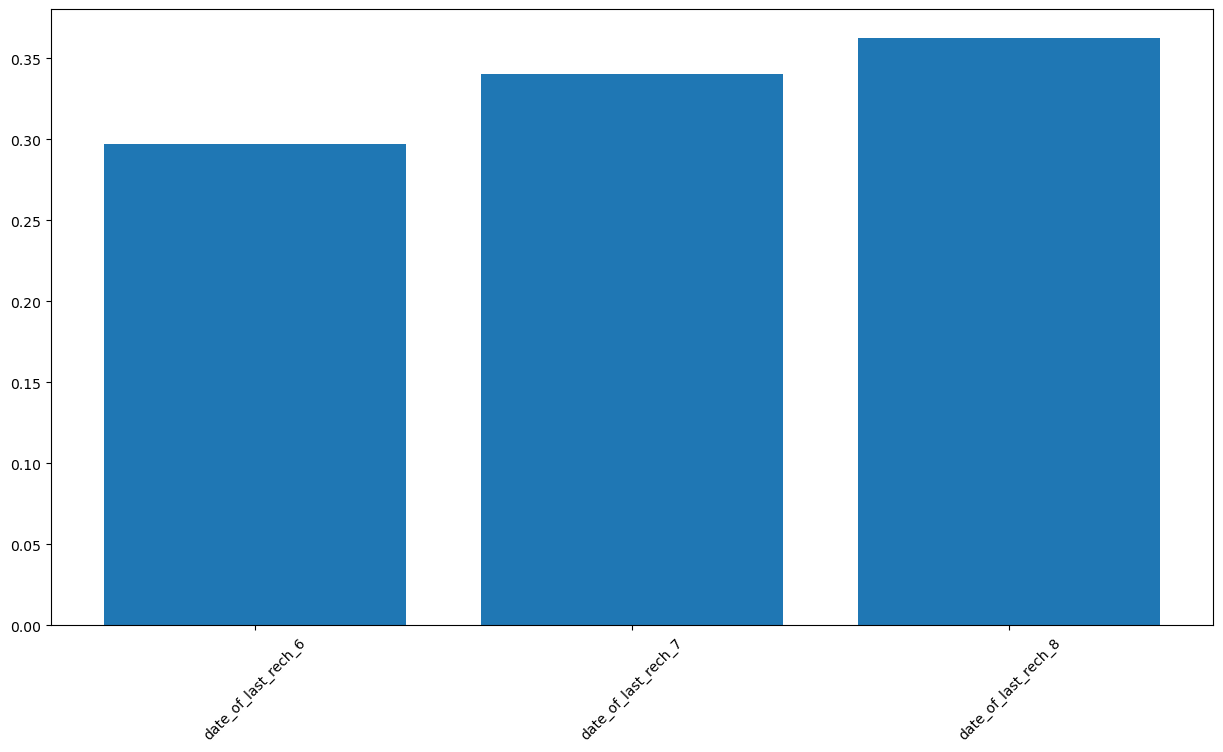

In [39]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

In [40]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)

<Axes: >

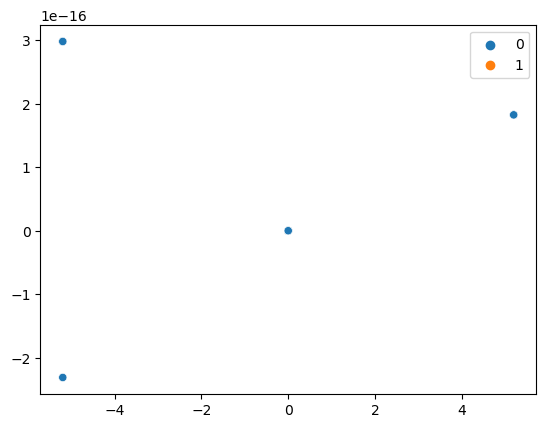

In [41]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train.to_numpy().reshape(-1,))

<Axes: >

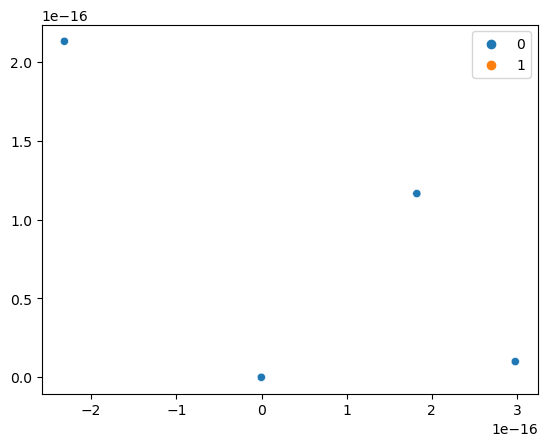

In [42]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train.to_numpy().reshape(-1,))

<Axes: >

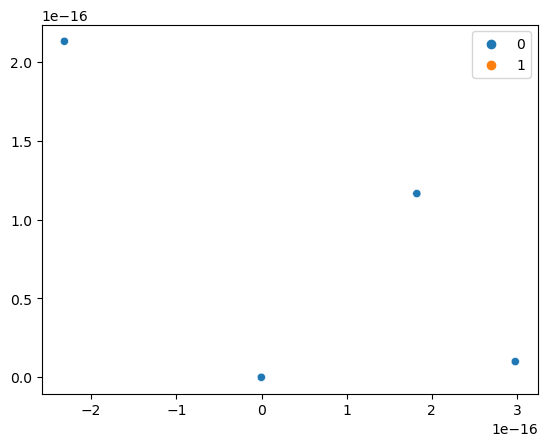

In [44]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train.to_numpy().reshape(-1,))

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [45]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

RandomForestClassifier(n_jobs=-1)

<BarContainer object of 3 artists>

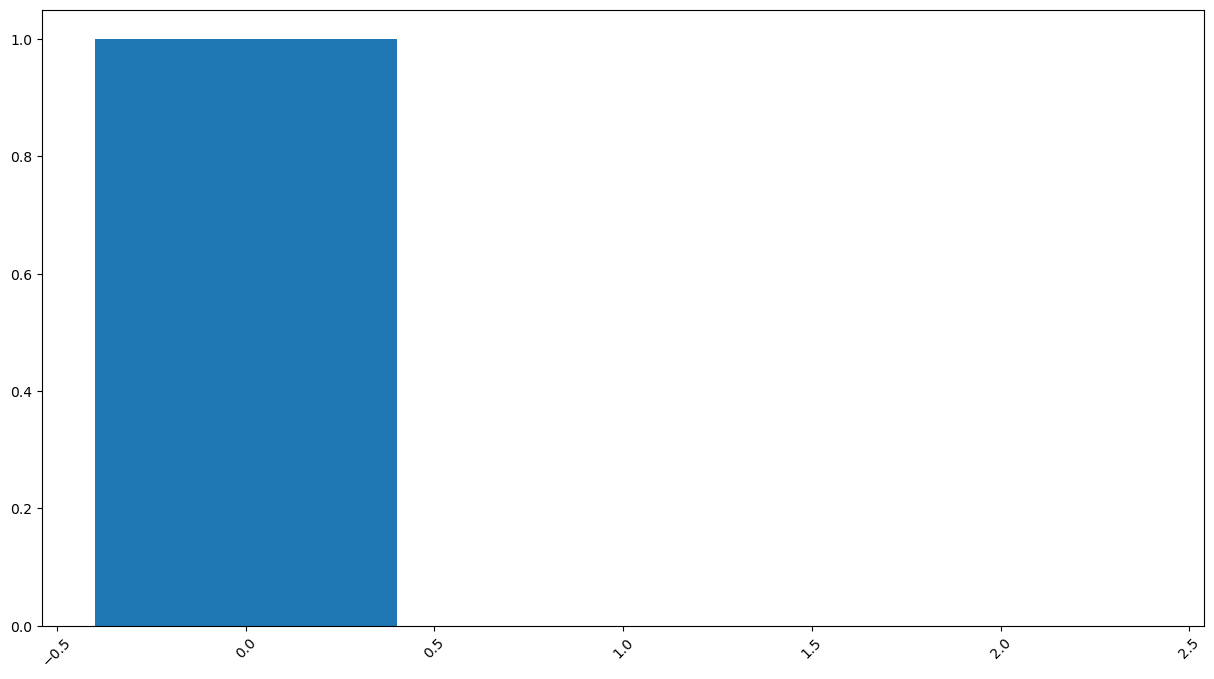

In [46]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(x = [i for i in range(len(rf.feature_importances_))], height=rf.feature_importances_)

## 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [47]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [48]:
lr.score(pca_components[:,:2], y_train)

0.8984981874676333

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" style="height: 300px; width:400px;"/>

Creating custom transformer for handling date time features:

In [49]:
def days(col):
    col2 = pd.to_datetime(col, format='%m/%d/%Y')
    return pd.DataFrame(31-col2.dt.day)

get_days_left = FunctionTransformer(func=days)

In [88]:
################# Neural networks model as part of Sklearn pipeline ##################################
######################################################################################################

def create_nn():
    
    model = Sequential(
        [
            layers.Dense(30,activation='relu', input_shape=(3,)),
            layers.Dense(10,activation='relu'),
            layers.Dense(1, activation='sigmoid'),
        ]
    )

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

######################################################################################################
######################################################################################################

In [102]:
#### Transform date columns and passthrough rest

from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

ct = ColumnTransformer(transformers=[('date_fix0', get_days_left, date_features[0]),
                                     ('date_fix1', get_days_left, date_features[1]),
                                     ('date_fix2', get_days_left, date_features[2]),
                                    ], remainder='passthrough')


##### Imputation, scaling and pca
imp = SimpleImputer(strategy='mean')
scale = StandardScaler()
pca = PCA()

#### Estimator
# model = LogisticRegression(max_iter=1000, tol=0.001)
model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
# model = SVC()
# model = KerasClassifier(build_fn=create_nn, batch_size=64, epochs=40, verbose=1) 

#### Pipeline
pipe = Pipeline(steps = [('dates',ct),
                         ('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',model)
                        ])

In [103]:
### Trying cross validation with different models models
# cv = cross_val_score(pipe, X_train[new_vars], y_train, cv=5, n_jobs=-1)
# cv

In [104]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('dates',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date_fix0',
                                                  FunctionTransformer(func=<function days at 0x00000251E4EAD620>),
                                                  'date_of_last_rech_8'),
                                                 ('date_fix1',
                                                  FunctionTransformer(func=<function days at 0x00000251E4EAD620>),
                                                  'date_of_last_rech_7'),
                                                 ('date_fix2',
                                                  FunctionTransformer(func=<function days at 0x00000251E4EAD620>),
                                                  'date_of_last_rech_6')])),
                ('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('pca', PCA()),
                ('model',
                 RandomForestClassifier(n_estimators=500, n_jobs=-1,
                                        random_state=42))])

In [105]:
predictions = pipe.predict(X_train[new_vars])

print("Training accuracy:", accuracy_score(y_train, predictions))
print(confusion_matrix(y_train, predictions))

Training accuracy: 0.9237486383685423
[[49989   326]
 [ 3944  1740]]


In [106]:
predictions = pipe.predict(X_test[new_vars])

print("Testing accuracy:", accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Testing accuracy: 0.8982857142857142
[[12350   202]
 [ 1222   226]]


## 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [107]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [108]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00,0
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84,0
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00,0
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00,0


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [109]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 3)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [110]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [111]:
output.to_csv('PrashantKumar_PrashantP_PiyushP_Submission5.csv',index=False)

We can now take this file and upload it as a submission on Kaggle.

In [112]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.5280373831775701

In [113]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.15607734806629833